<a href="https://colab.research.google.com/github/hydradon/clever-challenge/blob/master/part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An approach using a shallow (3-layer) neural network

In this notebook, I used the [DataFrame.shift](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) function to connect 2 consecutive events. The information of event t-1, and the features of event t are used as features to predict the class of event t. At first, I attempted to use only the features of event t-1, but the accuracy is very low (around 55%+ ).

I also attempted on LSTM but its performance is slightly lower than that of the conventional neural network layer.



# Data exploration

In [1]:
import pandas as pd

# Initial inspection shows that the timestamp column is Unix epoch time up to the Second granularity
dateparse = lambda timestamp: pd.to_datetime(timestamp, unit='s')

data = pd.read_csv("https://raw.githubusercontent.com/hydradon/clever-challenge/master/seq/sample.csv", 
                    index_col="timestamp",
                    date_parser=dateparse,
                    infer_datetime_format=True,
                    parse_dates=['timestamp'])
# View a sample of 10 rows
data.sample(5)

,event_id,class,f1,f2,f3,f3.1,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-23 16:20:32,818373,0,1,1,8,1.498174,41,40,9.250000,7,11.769902,8,78,0,45,9243,0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0
2017-09-11 13:10:16,812289,0,2,2,2,0.450561,11,7,695.000000,11,226.575312,2,8,0,0,9308,1,424.0,0,51.0,0.0,0,0.0,1,0,0,0,0,0,0,0,0,0
2018-07-24 15:45:43,823125,0,1,1,1,0.000000,4,4,4679.000000,11,610.061007,1,103,0,103,9721,1,704.0,0,514.0,0.0,0,0.0,1,0,0,0,0,0,0,0,0,0
2017-11-29 09:42:26,814219,1,1,15,63,3.317381,1762,336,106.793651,14,21.757563,42,121,0,121,9367,2,262.0,0,259.0,0.0,0,0.0,2,0,0,0,0,0,0,0,0,0
2017-03-29 09:06:37,811341,0,1,1,1,0.000000,9,0,317.000000,1,35.738229,1,243,0,167,9240,0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0


In [2]:
# Check any NA values
data.isna().sum()

# Inspect distribution of data
data.describe()

,event_id,class,f1,f2,f3,f3.1,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
count,18417.000000,18417.000000,18417.000000,18417.000000,18417.000000,18417.000000,1.841700e+04,1.841700e+04,18417.000000,18417.000000,18417.000000,18417.000000,18417.000000,18417.0,18417.000000,18417.000000,18417.000000,18417.000000,18417.0,18417.000000,18417.000000,18417.0,18417.000000,18417.000000,18417.0,18417.0,18417.0,18417.0,18417.0,18417.0,18417.0,18417.0,18417.0
mean,820275.000000,0.451539,1.083618,7.641527,46.805343,0.948172,5.282271e+03,1.876271e+03,662.242501,11.078732,230.087888,23.974589,6143.728675,0.0,3341.689743,8940.345387,0.953901,1417.993660,0.0,1023.482719,159.500034,0.0,51.891048,0.953901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,5316.674289,0.497660,0.408374,134.453030,1375.277466,1.077906,3.433018e+05,4.628975e+04,1103.655690,13.299995,192.331715,295.660614,21027.359733,0.0,11756.653978,1888.918706,0.765509,3499.505021,0.0,2666.322131,1175.169459,0.0,489.727322,0.765509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,811067.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-142.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,16.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,815671.000000,0.000000,1.000000,1.000000,1.000000,0.000000,4.000000e+00,1.000000e+00,88.000000,3.000000,68.332280,1.000000,218.000000,0.0,141.000000,9272.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,820275.000000,0.000000,1.000000,2.000000,3.000000,0.691761,2.200000e+01,8.000000e+00,286.680000,7.000000,180.443727,2.000000,741.000000,0.0,521.000000,9343.000000,1.000000,232.000000,0.0,174.000000,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,824879.000000,1.000000,1.000000,3.000000,8.000000,1.507725,1.200000e+02,4.800000e+01,771.500000,14.000000,358.026991,7.000000,2715.000000,0.0,1573.000000,9426.000000,1.000000,1011.000000,0.0,777.000000,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,829483.000000,1.000000,9.000000,16257.000000,172188.000000,10.287316,4.534482e+07,3.758535e+06,26059.000000,163.000000,714.998044,16095.000000,207897.000000,0.0,205927.000000,9982.000000,12.000000,40045.000000,0.0,37189.000000,11669.000000,0.0,11516.000000,12.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Looks like the following features only have constant 0 for all rows: f11, f16, f19, f22 - f30
const_col = ["f11", "f16", "f19"] + ["f{}".format(num) for num in range(22,31)]

# dropping these cols
data.drop(columns=const_col, inplace=True, errors='ignore')

In [7]:
# Read resource dataset
res = pd.read_csv("https://raw.githubusercontent.com/hydradon/clever-challenge/master/seq/res.csv")
res.sample(5)

,event_id,res_id
675425,820418,15683827
587745,817558,15644117
15262,811067,15340554
498808,815206,15558305
490753,815050,15611050


In [8]:
import numpy as np

def group_res_by_event(df):
    keys, values = df.sort_values('event_id').values.T
    ukeys, index = np.unique(keys, True)
    arrays = np.split(values, index[1:])
    df2 = pd.DataFrame({'event_id':ukeys, 'res_id':[list(a) for a in arrays]})
    return df2

res_grp = group_res_by_event(res)
res_grp

,event_id,res_id
0,811067,"[15325277, 15440054, 15440055, 15440056, 15440..."
1,811068,[15495262]
2,811069,"[15501813, 15501809, 15501812, 15501810, 15501..."
3,811070,"[15505228, 15505227, 15505225, 15505229, 15505..."
4,811071,"[15449230, 15449260, 15449270, 15449271, 15449..."
...,...,...
18303,829479,"[15475824, 15475827, 15475828, 15475830, 15475..."
18304,829480,"[15658697, 15658696]"
18305,829481,"[15666344, 15632590, 15548015, 15666343, 15632..."
18306,829482,"[15658538, 15695471, 15658424]"


In [9]:
# Merging 2 dataset
data_w_res = data.reset_index().merge(res_grp, on="event_id", how="left").set_index("timestamp")

# Fill event with no resource an empty resource list
data_w_res['res_id'] = data_w_res['res_id'].apply(lambda d: d if isinstance(d, list) else [])

data_w_res.head(5)

,event_id,class,f1,f2,f3,f3.1,f4,f5,f6,f7,f8,f9,f10,f12,f13,f14,f15,f17,f18,f20,f21,res_id
timestamp,,,,,,,,,,,,,,,,,,,,,,
2016-11-21 14:17:52,811067,1,9,16257,172188,10.287316,45344815,0,0.000000,1,0.000000,0,0,0,9230,0,0.0,0.0,0.0,0.0,0,"[15325277, 15440054, 15440055, 15440056, 15440..."
2016-12-01 16:23:01,811068,0,1,1,1,0.000000,2,1,3.000000,2,10.086910,1,0,0,9231,0,0.0,0.0,0.0,0.0,0,[15495262]
2016-12-02 09:14:02,811069,1,7,1731,10212,7.460379,2000330,84524,157.627693,1,2.579979,2442,172188,172076,9230,0,0.0,0.0,0.0,0.0,0,"[15501813, 15501809, 15501812, 15501810, 15501..."
2016-12-02 10:18:05,811070,0,1,4,12,1.665603,353,0,0.000000,1,0.000000,0,0,0,9232,0,0.0,0.0,0.0,0.0,0,"[15505228, 15505227, 15505225, 15505229, 15505..."
2016-12-02 10:18:39,811071,0,2,4,22,0.919741,6263,4346,684.409091,2,10.341428,21,12,0,9232,0,0.0,0.0,0.0,0.0,0,"[15449230, 15449260, 15449270, 15449271, 15449..."


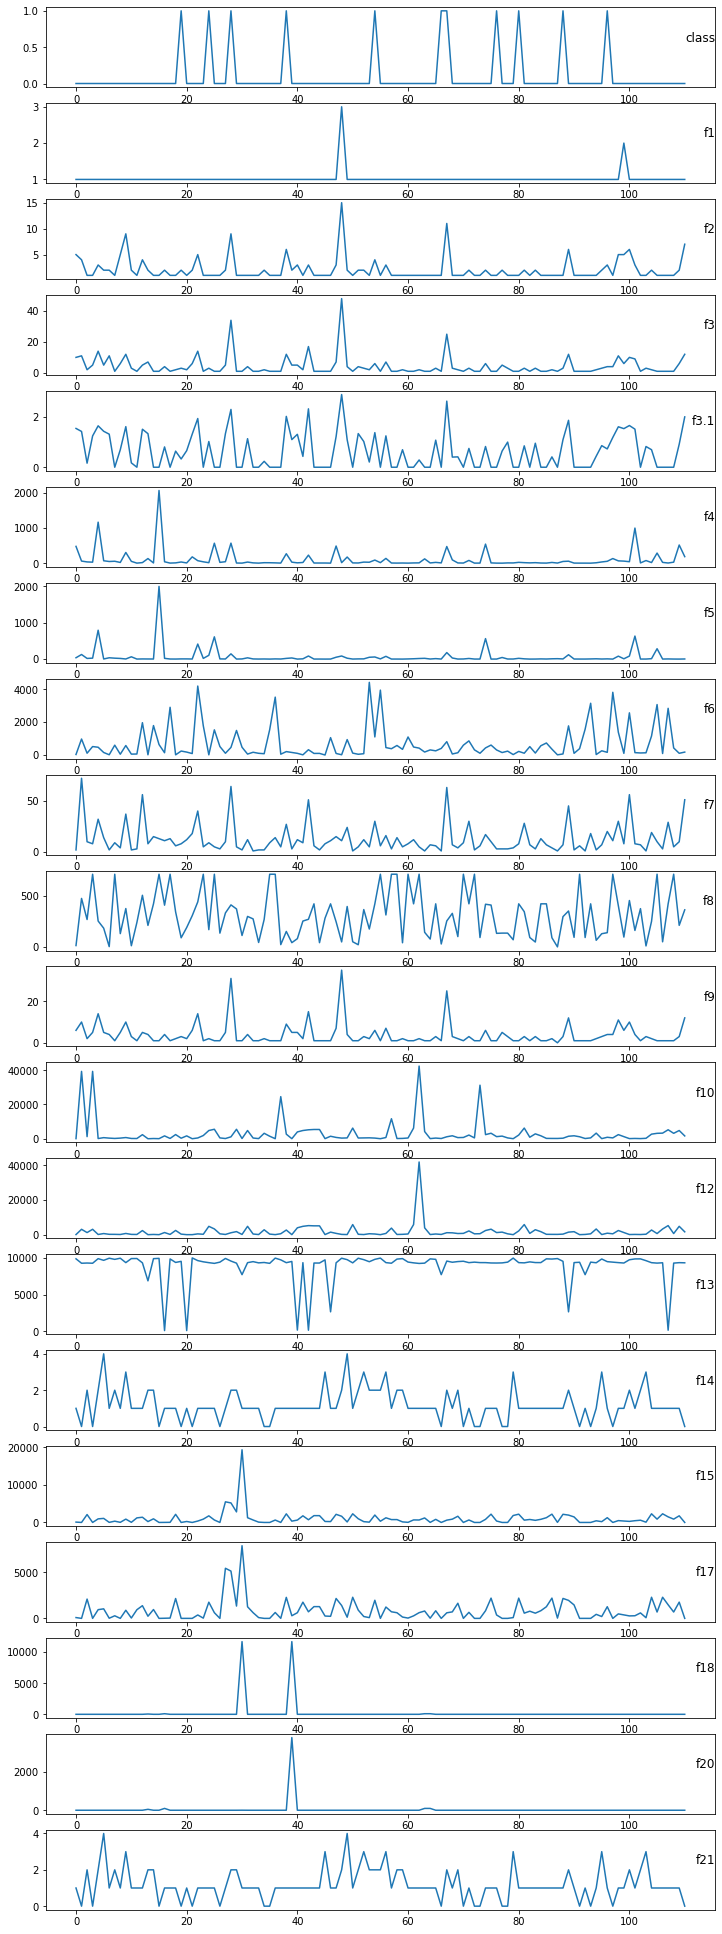

In [10]:
import matplotlib.pyplot as plt

# visualize class and features over a day (31st Oct 2018)
values = data_w_res.loc['2018-10-31 00:00:00':'2018-10-31 23:59:59'].values
# specify columns to plot
groups = list(range(1, 21))
i = 1
# plot each column
plt.rcParams["figure.figsize"] = 12,35
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(data_w_res.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In the end, I did not use res_id in this analysis. At first, I attempted to one-hot encoded the resource on my PC, I got memory error because there are 420,219 unique resources.

In [11]:
data_w_res.drop(columns=["res_id", "event_id"], inplace=True, errors='ignore') # Trial without using res_id
data_w_res["time_stamp"] = data_w_res.index
data_w_res.head(5)

,class,f1,f2,f3,f3.1,f4,f5,f6,f7,f8,f9,f10,f12,f13,f14,f15,f17,f18,f20,f21,time_stamp
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-11-21 14:17:52,1,9,16257,172188,10.287316,45344815,0,0.000000,1,0.000000,0,0,0,9230,0,0.0,0.0,0.0,0.0,0,2016-11-21 14:17:52
2016-12-01 16:23:01,0,1,1,1,0.000000,2,1,3.000000,2,10.086910,1,0,0,9231,0,0.0,0.0,0.0,0.0,0,2016-12-01 16:23:01
2016-12-02 09:14:02,1,7,1731,10212,7.460379,2000330,84524,157.627693,1,2.579979,2442,172188,172076,9230,0,0.0,0.0,0.0,0.0,0,2016-12-02 09:14:02
2016-12-02 10:18:05,0,1,4,12,1.665603,353,0,0.000000,1,0.000000,0,0,0,9232,0,0.0,0.0,0.0,0.0,0,2016-12-02 10:18:05
2016-12-02 10:18:39,0,2,4,22,0.919741,6263,4346,684.409091,2,10.341428,21,12,0,9232,0,0.0,0.0,0.0,0.0,0,2016-12-02 10:18:39


In [12]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

cur_data = data_w_res.copy()
encoder = LabelEncoder()
cur_data["class"] = encoder.fit_transform(cur_data["class"])

# scale feature columns
ft_cols = ['f1', 'f2', 'f3', 'f3.1', 'f4', 'f5', 'f6', 'f7',
            'f8', 'f9', 'f10', 'f12', 'f13', 'f14', 'f15', 
            'f17', 'f18', 'f20','f21'] # 19 features

# ensure all data is float
cur_data[ft_cols] = cur_data[ft_cols].astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
cur_data[ft_cols] = scaler.fit_transform(cur_data[ft_cols])

In [15]:
cur_data.head()

,class,f1,f2,f3,f3.1,f4,f5,f6,f7,f8,f9,f10,f12,f13,f14,f15,f17,f18,f20,f21,time_stamp
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-11-21 14:17:52,1,1.000000,1.000000,1.000000,1.000000,1.000000e+00,0.000000e+00,0.005420,0.006135,0.000000,0.000000,0.000000,0.000000,0.924543,0.0,0.0,0.0,0.0,0.0,0.0,2016-11-21 14:17:52
2016-12-01 16:23:01,0,0.111111,0.000062,0.000006,0.000000,4.410647e-08,2.660611e-07,0.005534,0.012270,0.014108,0.000062,0.000000,0.000000,0.924644,0.0,0.0,0.0,0.0,0.0,0.0,2016-12-01 16:23:01
2016-12-02 09:14:02,1,0.777778,0.106477,0.059307,0.725202,4.411375e-02,2.248855e-02,0.011436,0.006135,0.003608,0.151724,0.828237,0.835616,0.924543,0.0,0.0,0.0,0.0,0.0,0.0,2016-12-02 09:14:02
2016-12-02 10:18:05,0,0.111111,0.000246,0.000070,0.161908,7.784793e-06,0.000000e+00,0.005420,0.006135,0.000000,0.000000,0.000000,0.000000,0.924744,0.0,0.0,0.0,0.0,0.0,0.0,2016-12-02 10:18:05
2016-12-02 10:18:39,0,0.222222,0.000246,0.000128,0.089405,1.381194e-04,1.156302e-03,0.031541,0.012270,0.014464,0.001305,0.000058,0.000000,0.924744,0.0,0.0,0.0,0.0,0.0,0.0,2016-12-02 10:18:39


Convert series to supervised learning, using DataFrame.shift to match a class with previous class and previous class's features.

n_in = number of past events to used 

n_out = number of future events to predict

In [37]:
def get_lagged_data(dataframe, n_in=1, n_out=1, dropnan=True):
    data = dataframe.values
    df = pd.DataFrame(data, columns=dataframe.columns)
    cols, names = list(), list()

	# Processing the input sequence (t-n, ... t-1) slices
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('{}(t-{})'.format(j, i)) for j in dataframe.columns]

	# Processing the output sequence (t, t+1, ... t+n) slices
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('{}(t)'.format(j)) for j in dataframe.columns]
        else:
            names += [('{}(t+%d)'.format(j+1, i)) for j in dataframe.columns]
	
    # Concatenate all time lagged dataframe slices
    final = pd.concat(cols, axis=1)
    final.columns = names

	# drop rows with NaN values, because we shift columns up and down, 
    # some NaN values will be padded at either ends of the dataframe.
    if dropnan:
        final.dropna(inplace=True)
    return final

Tie one past event to forecast one event forward.

This can be applied to multi-step forward (by setting n_out = 5, 10) and using the last n_in events,

In [21]:
data_shifted = get_lagged_data(cur_data, n_in=1, n_out=1)
print(data_shifted.shape) # Should be 1 row less than before processing due to shifting by 1
print(data_shifted.columns)

(18416, 42)
Index(['class(t-1)', 'f1(t-1)', 'f2(t-1)', 'f3(t-1)', 'f3.1(t-1)', 'f4(t-1)',
       'f5(t-1)', 'f6(t-1)', 'f7(t-1)', 'f8(t-1)', 'f9(t-1)', 'f10(t-1)',
       'f12(t-1)', 'f13(t-1)', 'f14(t-1)', 'f15(t-1)', 'f17(t-1)', 'f18(t-1)',
       'f20(t-1)', 'f21(t-1)', 'time_stamp(t-1)', 'class(t)', 'f1(t)', 'f2(t)',
       'f3(t)', 'f3.1(t)', 'f4(t)', 'f5(t)', 'f6(t)', 'f7(t)', 'f8(t)',
       'f9(t)', 'f10(t)', 'f12(t)', 'f13(t)', 'f14(t)', 'f15(t)', 'f17(t)',
       'f18(t)', 'f20(t)', 'f21(t)', 'time_stamp(t)'],
      dtype='object')


In [22]:
# Verify the correct sequence of class at time t-1 and next instance t
data_shifted[["class(t-1)", 'time_stamp(t-1)', "class(t)", 'time_stamp(t)']].head(16)

,class(t-1),time_stamp(t-1),class(t),time_stamp(t)
1,1,2016-11-21 14:17:52,0,2016-12-01 16:23:01
2,0,2016-12-01 16:23:01,1,2016-12-02 09:14:02
3,1,2016-12-02 09:14:02,0,2016-12-02 10:18:05
4,0,2016-12-02 10:18:05,0,2016-12-02 10:18:39
5,0,2016-12-02 10:18:39,0,2016-12-02 15:35:26
6,0,2016-12-02 15:35:26,0,2016-12-02 16:58:26
7,0,2016-12-02 16:58:26,0,2016-12-08 17:07:09
8,0,2016-12-08 17:07:09,0,2016-12-09 13:43:08
9,0,2016-12-09 13:43:08,1,2016-12-12 13:30:33
10,1,2016-12-12 13:30:33,1,2016-12-13 13:16:32


## Preparing data for training

I attempted to use only features of past events, but that did not give high accuracy.

In [ ]:
# Drop all features of instance t (the instance we need to predict
# since we only know the features at instance t-1)
# Note that t-1 is the NOW, t is the future to predict
# future_ft = ['f1(t)', 'f2(t)', 'f3(t)', 'f3.1(t)', 'f4(t)', 'f5(t)', 'f6(t)', 'f7(t)', 'f8(t)', 'f9(t)',
#             'f10(t)', 'f12(t)', 'f13(t)', 'f14(t)', 'f15(t)', 'f17(t)', 'f18(t)', 'f20(t)', 'f21(t)']
# data_shifted.drop(columns=future_ft, inplace=True, errors='ignore')
# data_shifted.head(5)

In [27]:
from sklearn.model_selection import train_test_split

# Separate into input and output
features = [x for x in data_shifted.columns if x not in ['time_stamp(t-1)', 'time_stamp(t)', 'class(t)']]
output =  ['class(t)']

train_X, test_X, train_y, test_y = train_test_split(data_shifted[features], data_shifted[output], test_size = 0.2, random_state=0)
train_X, train_y = train_X.astype('float32'), train_y.astype('float32')
test_X, test_y = test_X.astype('float32'), test_y.astype('float32')

In [28]:
# reshape input to be 3D [samples, timesteps, features]
train_X_val = train_X.values
train_X_val = train_X_val.reshape((train_X_val.shape[0], train_X.shape[1])) # If using LSTM, need to add a dimension of 1 (timestep = 1) in between these 2 dimesions

test_X_val = test_X.values
test_X_val = test_X_val.reshape((test_X_val.shape[0], test_X_val.shape[1]))

train_y_val = train_y.values.reshape(len(train_y))
test_y_val = test_y.values.reshape(len(test_y))
# train_y_val = train_y.values
# test_y_val = test_y.values

print(train_X_val.shape, train_y_val.shape, test_X_val.shape, test_y_val.shape)
# print(type(train_X_val), type(train_y_val), type(test_X_val), type(test_y_val))

(14732, 39) (14732,) (3684, 39) (3684,)


## Building a shallow neural network

At first, I used LSTM as the first layer but that gave an accuracy of about 68%.

Structure: 
- 1 Dense layer with dropout (to reduce overfitting)
- 1 Hidden layer
- 1 output layer with sigmoid activation (for binary classification)

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout
from keras.metrics import binary_accuracy

np.random.seed(7)

model = Sequential()
# model.add(LSTM(100, 
#                input_shape=(train_X_val.shape[1], train_X_val.shape[2]), # Input: time step * number of features
#                activation='relu'))
model.add(Dense(128, 
               input_dim=train_X_val.shape[1],
               activation='relu')) 

model.add(Dropout(0.2))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))

# Output layer with binary Classification 0 or 1
model.add(Dense(1, activation='sigmoid')) 

# Compile
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy']) # binary_crossentropy for binary categorical label (0, 1)

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               5120      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 21,761
Trainable params: 21,761
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
from keras.callbacks import ModelCheckpoint
import os

# checkpoint_path = "./part3models/training_1/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = ModelCheckpoint(filepath=checkpoint_path,
#                               save_weights_only=True,
#                               verbose=1)

# Fitting
history = model.fit(train_X_val, train_y_val,
                    epochs=30, batch_size=10,
                    validation_data=(test_X_val, test_y_val),
                    # callbacks=[cp_callback],
                    verbose=2, shuffle=False)

Epoch 1/30
1474/1474 - 4s - loss: 0.5972 - accuracy: 0.6865 - val_loss: 0.5661 - val_accuracy: 0.7142
Epoch 2/30
1474/1474 - 3s - loss: 0.5751 - accuracy: 0.7092 - val_loss: 0.5626 - val_accuracy: 0.7174
Epoch 3/30
1474/1474 - 3s - loss: 0.5708 - accuracy: 0.7101 - val_loss: 0.5596 - val_accuracy: 0.7212
Epoch 4/30
1474/1474 - 3s - loss: 0.5657 - accuracy: 0.7150 - val_loss: 0.5584 - val_accuracy: 0.7196
Epoch 5/30
1474/1474 - 3s - loss: 0.5643 - accuracy: 0.7167 - val_loss: 0.5564 - val_accuracy: 0.7220
Epoch 6/30
1474/1474 - 3s - loss: 0.5607 - accuracy: 0.7167 - val_loss: 0.5553 - val_accuracy: 0.7207
Epoch 7/30
1474/1474 - 3s - loss: 0.5602 - accuracy: 0.7185 - val_loss: 0.5540 - val_accuracy: 0.7226
Epoch 8/30
1474/1474 - 4s - loss: 0.5589 - accuracy: 0.7190 - val_loss: 0.5542 - val_accuracy: 0.7215
Epoch 9/30
1474/1474 - 4s - loss: 0.5574 - accuracy: 0.7212 - val_loss: 0.5555 - val_accuracy: 0.7196
Epoch 10/30
1474/1474 - 3s - loss: 0.5561 - accuracy: 0.7220 - val_loss: 0.5545 - 

## Evaluate the model

In [31]:
# evaluate the keras model
_, accuracy = model.evaluate(test_X_val, test_y_val)
print('Accuracy: %.2f %%' % (accuracy*100)) 

116/116 [==============================] - 0s 2ms/step - loss: 0.5639 - accuracy: 0.7215
Accuracy: 72.15 %


It looks like the validation loss reaches the minimum after 10 epochs.

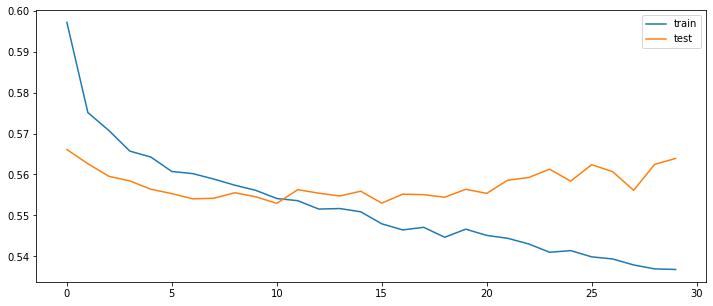

In [32]:
# plot history
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 12,5

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# model.save("./part3models/")


INFO:tensorflow:Assets written to: ./part3models/assets


In [ ]:
# from tensorflow import keras
# model = keras.models.load_model('./part3models/')

### Calculating precision and recall

(Is it the part of your paper on detecting risky and non-risky commits based on several code metrics?)



In [33]:
# make a prediction
yhat = model.predict(test_X_val)
# Convert to 1 and 0
test_y_val_bool = test_y_val.reshape(len(test_y_val))
yhat_bool = yhat.round().reshape(len(yhat))

In [36]:
from sklearn.metrics import precision_score, recall_score
print("Precision: {:.2f} %".format(precision_score(test_y_val_bool, yhat_bool) * 100))
print("Recall: {:.2f} %".format(recall_score(test_y_val_bool, yhat_bool) * 100))

Precision: 72.05 %
Recall: 61.73 %
